<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Tackling an NLP Problem with Naive Bayes
_Author: Matt Brems_

----

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we are going to apply a **new** modeling technique to natural language processing data.

> "But how can we apply a modeling technique we haven't learned?!"

The DSI program is great - but we can't teach you *everything* about data science in 12 weeks! This lab is designed to help you start learning something new without it being taught in a formal lesson. 
- Later in the cohort (like for your capstone!), you'll be exploring models, libraries, and resources that you haven't been explicitly taught.
- After the program, you'll want to continue developing your skills. Being comfortable with documentation and being confident in your ability to read something new and decide whether or not it is an appropriate method for the problem you're trying to solve is **incredibly** valuable.

### Step 1: Define the problem.

Many organizations have a substantial interest in classifying users of their product into groups. Some examples:
- A company that serves as a marketplace may want to predict who is likely to purchase a certain type of product on their platform, like books, cars, or food.
- An application developer may want to identify which individuals are willing to pay money for "bonus features" or to upgrade their app.
- A social media organization may want to identify who generates the highest rate of content that later goes "viral."

### Summary
In this lab, you're an engineer for Facebook. In recent years, the organization Cambridge Analytica gained worldwide notoriety for its use of Facebook data in an attempt to sway electoral outcomes.

Cambridge Analytica, an organization staffed with lots of Ph.D. researchers, used the Big5 personality groupings (also called OCEAN) to group people into one of 32 different groups.
- The five qualities measured by this personality assessment are:
    - **O**penness
    - **C**onscientiousness
    - **E**xtroversion
    - **A**greeableness
    - **N**euroticism
- Each person could be classified as "Yes" or "No" for each of the five qualities.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$)
- You don't have to check it out, but if you want to learn more about this personality assessment, head to [the Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits).
- There's also [a short (3-4 pages) academic paper describing part of this approach](./celli-al_wcpr13.pdf).

Cambridge Analytica's methodology was, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big5 personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

You want to know the **real-world problem**: "Is what Cambridge Analytica attempted to do actually possible, or is it junk science?"

However, we'll solve the related **data science problem**: "Are one's Facebook statuses predictive of whether or not one is agreeable?"
> Note: If Facebook statuses aren't predictive of one being agreeable (one of the OCEAN qualities), then Cambridge Analytica's approach won't work very well!

### Step 2: Obtain the data.

Obviously, there are plenty of opportunities to discuss the ethics surrounding this particular issue... so let's do that.

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report, mean_squared_error, r2_score

# Imports natural Language for analyze text review
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import re
import string

# Warning
import warnings
warnings.filterwarnings("ignore")

# This setting widens how many characters pandas will display 
# in a column:
pd.options.display.max_colwidth = 400

In [2]:
# Read dataset
data = pd.read_csv('./mypersonality_final.csv', encoding = 'ISO-8859-1')

In [3]:
# View first 5 row
data.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


In [4]:
# Check shape
data.shape

(9917, 20)

In [5]:
# Check types
data.dtypes

#AUTHID          object
STATUS           object
sEXT            float64
sNEU            float64
sAGR            float64
sCON            float64
sOPN            float64
cEXT             object
cNEU             object
cAGR             object
cCON             object
cOPN             object
DATE             object
NETWORKSIZE     float64
BETWEENNESS     float64
NBETWEENNESS    float64
DENSITY         float64
BROKERAGE       float64
NBROKERAGE      float64
TRANSITIVITY    float64
dtype: object

In [6]:
# Check missing values
data.isnull().sum()

#AUTHID         0
STATUS          0
sEXT            0
sNEU            0
sAGR            0
sCON            0
sOPN            0
cEXT            0
cNEU            0
cAGR            0
cCON            0
cOPN            0
DATE            0
NETWORKSIZE     0
BETWEENNESS     0
NBETWEENNESS    0
DENSITY         0
BROKERAGE       0
NBROKERAGE      0
TRANSITIVITY    1
dtype: int64

In [7]:
data[data["TRANSITIVITY"].isnull() == True]

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
6399,b576dc0449e75306c30456902ce0c80b,"To those with interest in international politics and policy I recommend : ""THE POST-AMERICAN WORLD"" By *PROPNAME* 3.84",3.84,2.6,3.75,4.0,4.15,y,n,y,y,y,254,29724.9,93.25,0.04,30978.0,0.49,0.18,NaN


In [8]:
# Only 1 of missing value 
# We decide drop 
data.dropna(inplace=True)

In [9]:
# View
data.isnull().sum()

#AUTHID         0
STATUS          0
sEXT            0
sNEU            0
sAGR            0
sCON            0
sOPN            0
cEXT            0
cNEU            0
cAGR            0
cCON            0
cOPN            0
DATE            0
NETWORKSIZE     0
BETWEENNESS     0
NBETWEENNESS    0
DENSITY         0
BROKERAGE       0
NBROKERAGE      0
TRANSITIVITY    0
dtype: int64

**1. What is the difference between anonymity and confidentiality? All else held equal, which tends to keep people safer?**

- Anonymity means you don’t know who the participants are
- Confidentiality means you know who they are but remove identifying information from your research report. 
- Both are important ethical considerations.
- Federal law does allow an IRB to waive the requirement for signed consent documents in cases where the collection of that document is the only identifying information linking the subject to the project.
- credit : https://www.evergreen.edu/humansubjectsreview/confidentiality

**2. Suppose that the "unique identifier" in the above data, the `#AUTHID`, is a randomly generated key so that it can never be connected back to the original poster. Have we guaranteed anonymity here? Why or why not?**

I don't think that we can guarantee anonymity here. It is most likely challenging to connect back to the original poster because #AUTHID is a randomly generated key, but maybe with status post and date/time we may search in actual data or collected sources.

**3. As an engineer for Facebook, you recognize that user data will be used by Facebook and by other organizations - that won't change. However, what are at least three recommendations you would bring to your manager to improve how data is used and shared? Be as specific as you can.**

- Don’t collect data you don’t need to collect.
- Tell people how you handle data and ask for permission
- Choose anonymity over confidentiality where possible.
<br>Even if you receive consent to use information, try to make sure the information is not able to be traced back to the individual.

### Step 3: Explore the data.

- Note: For our $X$ variable, we will only use the `STATUS` variable. For our $Y$ variable, we will only use the `cAGR` variable.

**4. Explore the data here.**
> We aren't explicitly asking you to do specific EDA here, but what EDA would you generally do with this data? Do the EDA you usually would, especially if you know what the goal of this analysis is.

<AxesSubplot:>

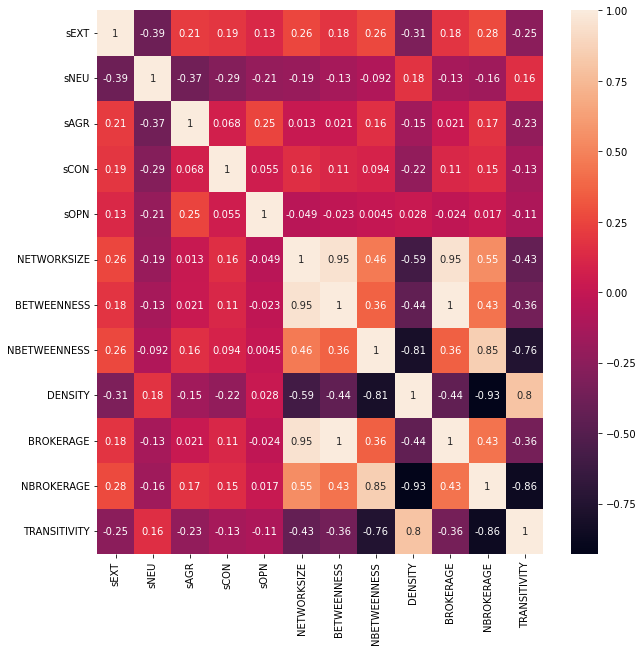

In [10]:
# Create heatmap to explore correlation
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),
           annot=True)

<Figure size 720x720 with 0 Axes>

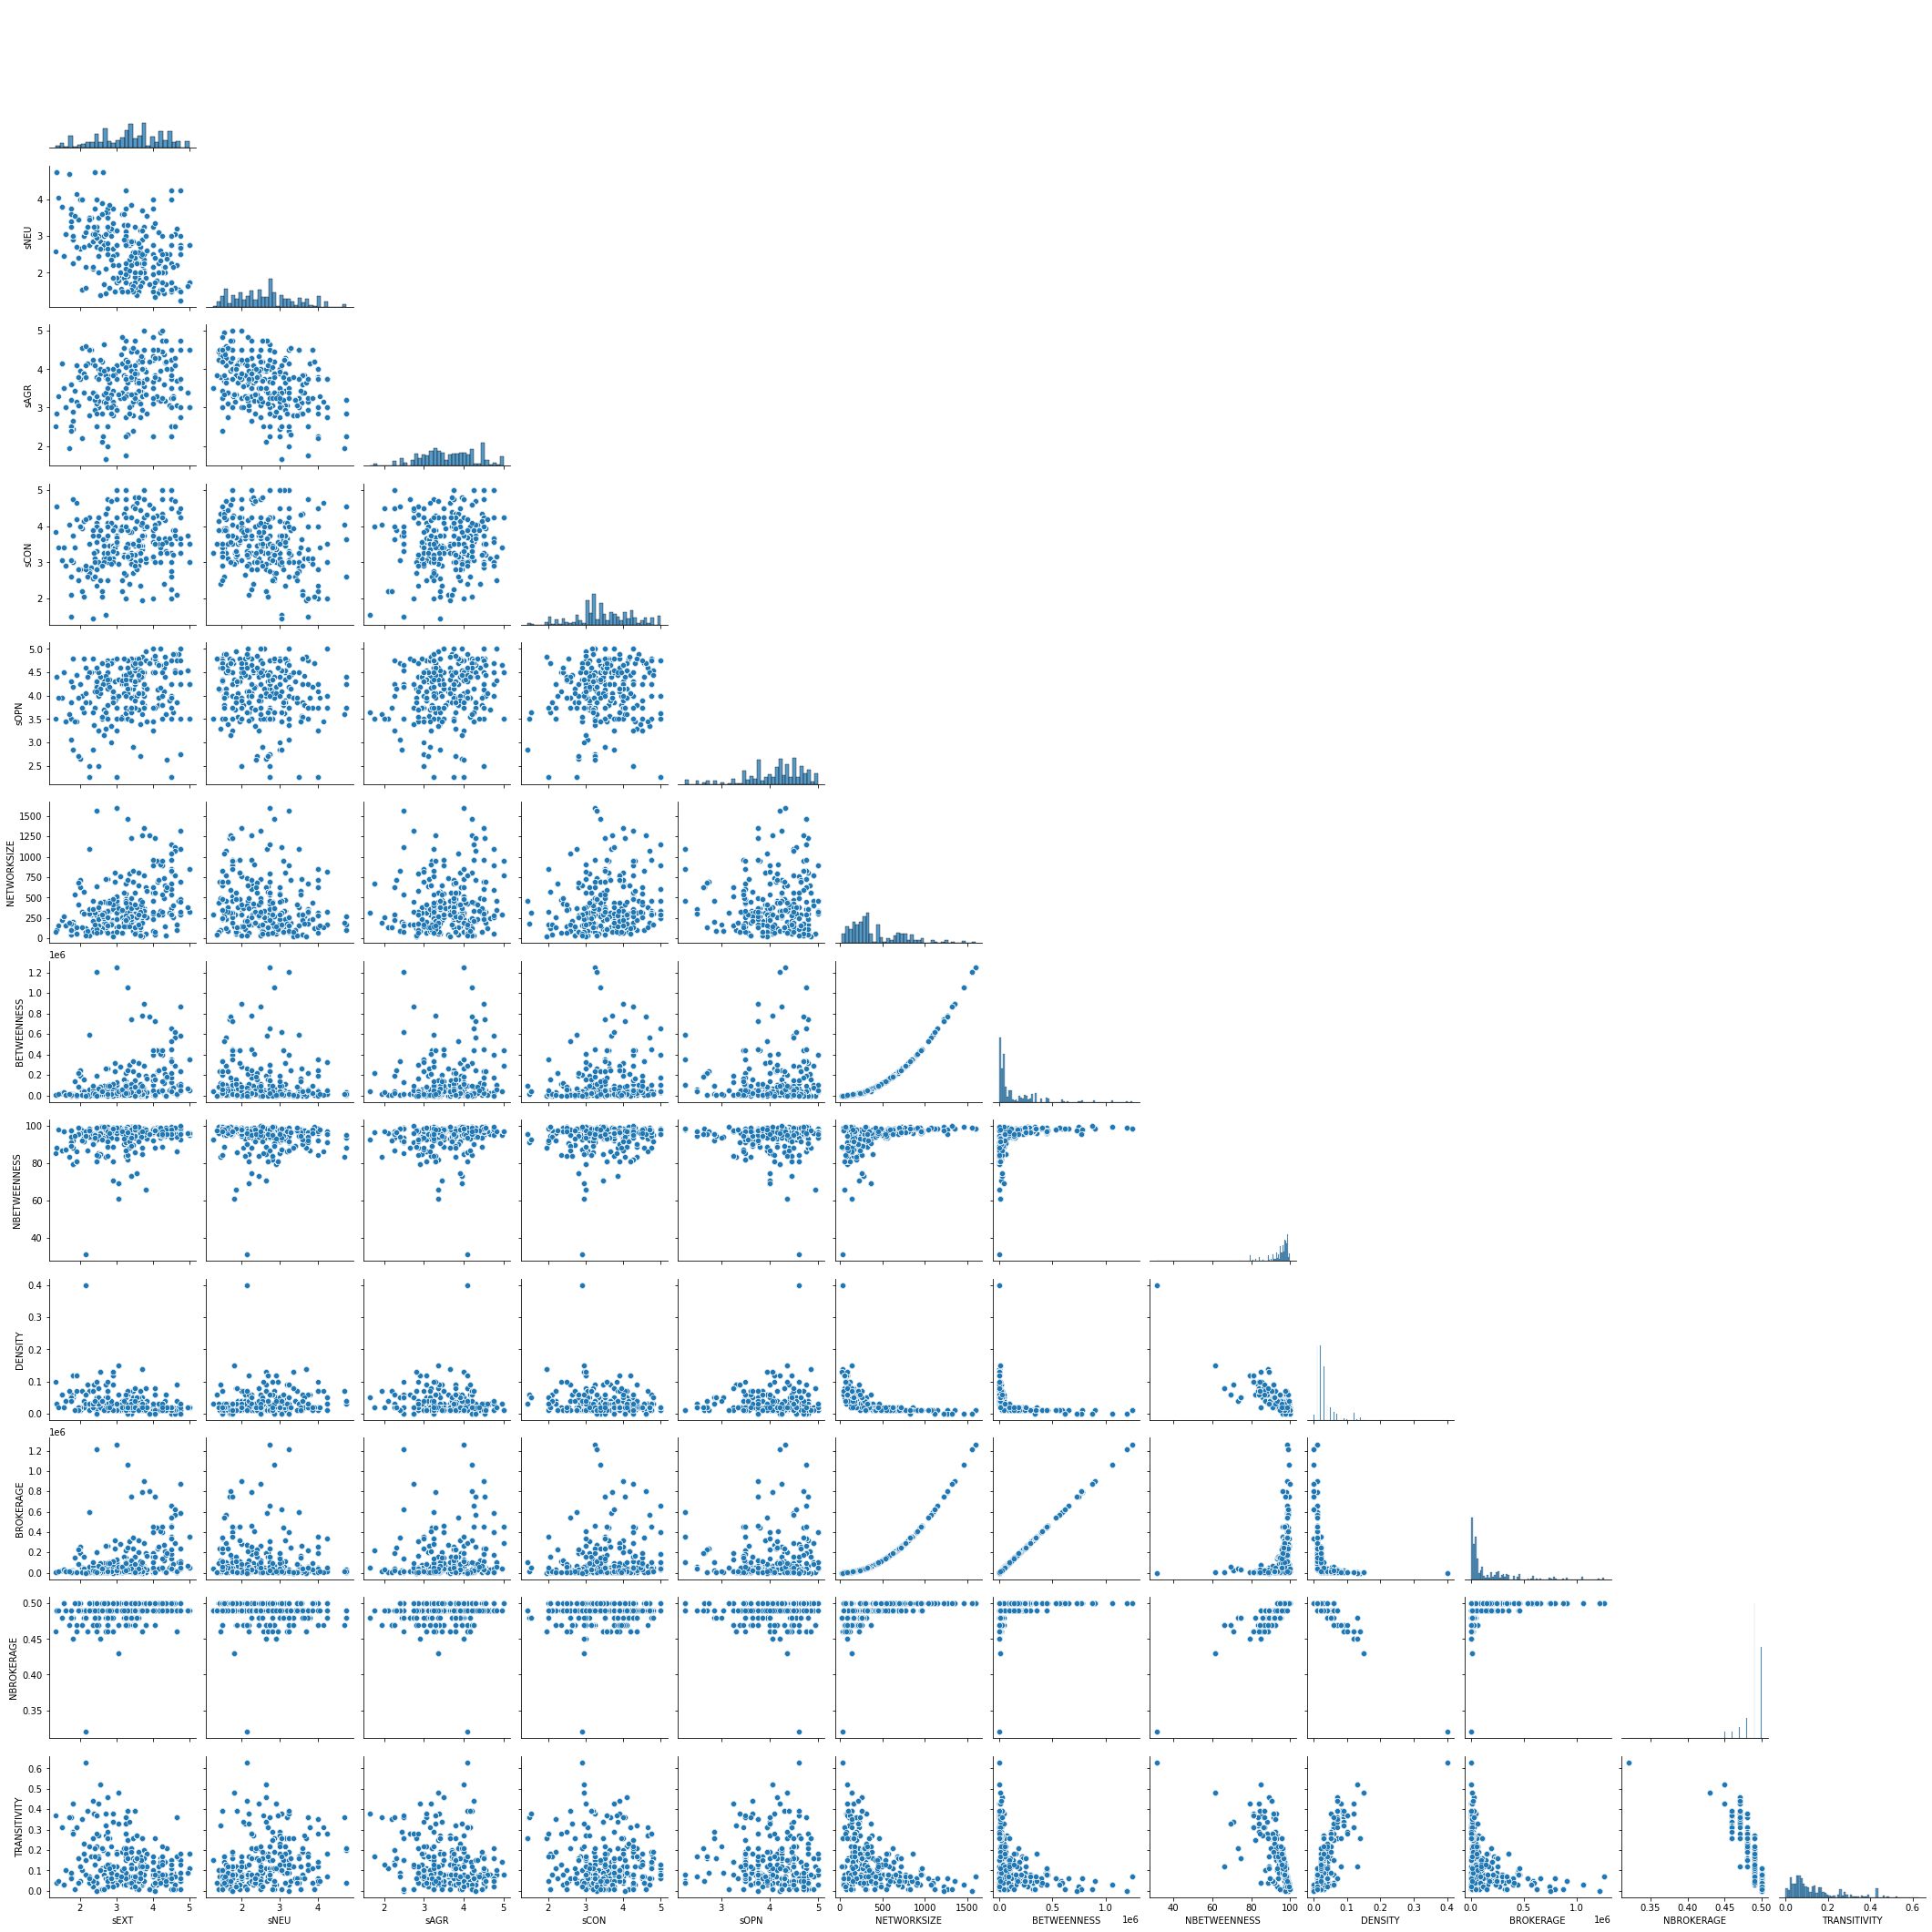

In [11]:
# Create pairplot to explore graph
plt.figure(figsize=(10,10))
sns.pairplot(data, corner=True);

**5. What is the difference between CountVectorizer and TFIDFVectorizer?**

- CountVectorizer return a count of the token(word) times is observed
- TFIDFVectorizer return log term of the frequency of a token(word) in the corpus

 https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/
 
TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

**6. What are stopwords?**

In [12]:
# Stop words are typically articles, prepositions, conjunctions, or pronouns. 
# They don't change the meaning and are mostly used when writing/speaking
# to structure sentences properly.

**7. Give an example of when you might remove stopwords.**

In [13]:
text = "We like Doing Projects and Labs"
# Remove stopwords from "text"
tokenizer = RegexpTokenizer(r'\w+')
text_tokens = tokenizer.tokenize(text.lower())
no_stop_words = \
[token for token in text_tokens if token not in stopwords.words('english')]

# Remove stopword form text 
# Before: We like Doing Projects and Labs
# After remove: 'like', 'projects', 'labs' 
# From example 'we' 'doing' 'and' are very common word 
# but after remove this meaning still information can understand  
no_stop_words

['like', 'projects', 'labs']

**8. Give an example of when you might keep stopwords in your model.**

In [14]:
text = "not good not funny not happy"
# Remove stopwords from "text"
tokenizer = RegexpTokenizer(r'\w+')
text_tokens = tokenizer.tokenize(text.lower())
no_stop_words = \
[token for token in text_tokens if token not in stopwords.words('english')]
# If text data includes a lot of "not" --> "not good", "not funny", "not happy"
# those meaning is bad right 
# when we use stopwords in your mode, the meaning is changed by stopwords
# So we should  keep stopwords in our model
no_stop_words

['good', 'funny', 'happy']

### Step 4: Model the data.

We are going to fit two types of models: a logistic regression and [a Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html).

**Reminder:** We will only use the feature `STATUS` to model `cAGR`.

In [15]:
# Change target to binary values 
data["cAGR"] = data["cAGR"].map({"y":1, "n":0})

### We want to attempt to fit our models on sixteen sets of features:

1. CountVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
2. CountVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
3. CountVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
4. CountVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
5. CountVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
6. CountVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
7. CountVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
8. CountVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.
9. TFIDFVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
10. TFIDFVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
11. TFIDFVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
12. TFIDFVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
13. TFIDFVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
14. TFIDFVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
15. TFIDFVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
16. TFIDFVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.

**9. Rather than manually instantiating 16 different vectorizers, what `sklearn` class have we learned about that might make this easier? Use it.**

In [16]:
def get_metric(X_train,X_test,y_train,y_test, models, model_dict):

    ''' Show the overall metric model
    
    Parameter : 
                X_test = test data of X
                y_test = test data of y
                model = trainned model 
                model_dict(Dictionary) must have keys follow below: 
                'model_vectorizer':[],
                "model_classification" :[],
                "best_para" : [], 
                'accuracy_training': [], 
                "accuracy_testing" : [],
                'true_negatives':[], 
                'false_positives':[],'
                false_negatives':[],
                'true_positives':[], 
                'precision' : [], 
                'recall' : [],
                'F1_training':[], 
                'F1_testing':[]}
                
    Return : Add value of model to model_dict '''
    
    # Predict model 
    y_train_pred = models.predict(X_train)
    y_test_pred = models.predict(X_test)
    
    
    model_dict['model_vectorizer'].append(str(models.best_estimator_[0])[:str(models.best_estimator_[0]).find("(")])
    model_dict['model_classification'].append(str(models.best_estimator_[1]))
    model_dict["best_para"].append(models.best_params_)
    model_dict['accuracy_training'].append(accuracy_score(y_train, y_train_pred))
    model_dict['accuracy_testing'].append(accuracy_score(y_test, y_test_pred))
    model_dict['true_negatives'].append(confusion_matrix(y_test, y_test_pred).ravel()[0])
    model_dict['false_positives'].append(confusion_matrix(y_test, y_test_pred).ravel()[1])
    model_dict['false_negatives'].append(confusion_matrix(y_test, y_test_pred).ravel()[2])
    model_dict['true_positives'].append(confusion_matrix(y_test, y_test_pred).ravel()[3])
    model_dict["precision"].append(round(precision_score(y_test, y_test_pred),2))
    model_dict["recall"].append(round(recall_score(y_test, y_test_pred),2))
    model_dict['F1_training'].append(round(f1_score(y_train, y_train_pred),2))
    model_dict['F1_testing'].append(round(f1_score(y_test, y_test_pred),2))

In [17]:
# Make pipeline and features of CountVectorizer and TFIDFVectorizer
pipe_cvec_lr = Pipeline([('cvec', CountVectorizer()),
                 ('lr', LogisticRegression())])

pipe_cvec_mn = Pipeline([('cvec', CountVectorizer()),
                 ('mn', MultinomialNB())])

pipe_tvec_lr = Pipeline([('tvec', TfidfVectorizer()),
                 ('lr', LogisticRegression())])

pipe_tvec_mn = Pipeline([('tvec', TfidfVectorizer()),
                 ('mn', MultinomialNB())])

pipe_params_cvec = {
              'cvec__max_features': [None, 'english'],
              'cvec__max_features': [100, 500],
              'cvec__ngram_range': [(1,1), (1,2)],
                }

pipe_params_tvec = {
              'tvec__max_features': [None, 'english'],
              'tvec__max_features': [100, 500],
              'tvec__ngram_range': [(1,1), (1,2)],
                }

# Make dict for add detail of each model
model_dict = {'model_vectorizer':[], 'model_classification':[], "best_para" : [], 
                'accuracy_training': [], "accuracy_testing" : [],
                'true_negatives':[], 'false_positives':[],'false_negatives':[],'true_positives':[], 
                'precision' : [], 'recall' : [],
                'F1_training':[], 'F1_testing':[]}

In [18]:
# Define X and y
X = data["STATUS"]
y = data["cAGR"]

In [19]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## CountVectorizer

In [20]:
# Gridsearch CountVectorizer of LogisticRegression model
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, 
                  param_grid=pipe_params_cvec, 
                  cv=5).fit(X_train, y_train)
print(gs_cvec_lr.best_score_)
print(gs_cvec_lr.best_params_)

0.5440298439808897
{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}


In [21]:
# Gridsearch CountVectorizer of MultinomialNB model
gs_cvec_mn = GridSearchCV(pipe_cvec_mn, 
                  param_grid=pipe_params_cvec, 
                  cv=5).fit(X_train, y_train)
print(gs_cvec_mn.best_score_)
print(gs_cvec_mn.best_params_)

0.5387606860851986
{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}


## TFIDFVectorizer

In [22]:
# Gridsearch TFIDFVectorizer of LogisticRegression model
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, 
                  param_grid=pipe_params_tvec, 
                  cv=5).fit(X_train, y_train)
print(gs_tvec_lr.best_score_)
print(gs_tvec_lr.best_params_)

0.5471929478636895
{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}


In [23]:
# Gridsearch TFIDFVectorizer of MultinomialNB model
gs_tvec_mn = GridSearchCV(pipe_tvec_mn, 
                  param_grid=pipe_params_tvec, 
                  cv=5).fit(X_train, y_train)
print(gs_tvec_mn.best_score_)
print(gs_tvec_mn.best_params_)

0.551556338219696
{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}


In [24]:
# Loop oe each model to add value in model_dict
for model in (gs_cvec_lr, gs_cvec_mn, gs_tvec_lr, gs_tvec_mn):
    get_metric(X_train, X_test, y_train, y_test, model, model_dict)

# Make dataframe to show matrix values of each models
model_df = pd.DataFrame(model_dict)
model_df

,model_vectorizer,model_classification,best_para,accuracy_training,accuracy_testing,true_negatives,false_positives,false_negatives,true_positives,precision,recall,F1_training,F1_testing
0,CountVectorizer,LogisticRegression(),"{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}",0.634804,0.545677,633,902,585,1153,0.56,0.66,0.68,0.61
1,CountVectorizer,MultinomialNB(),"{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}",0.612073,0.543844,616,919,574,1164,0.56,0.67,0.67,0.61
2,TfidfVectorizer,LogisticRegression(),"{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}",0.634201,0.537122,575,960,555,1183,0.55,0.68,0.69,0.61
3,TfidfVectorizer,MultinomialNB(),"{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}",0.623513,0.531317,441,1094,440,1298,0.54,0.75,0.70,0.63


In [25]:
# Show overall
model_df.T

,0,1,2,3
model_vectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer,TfidfVectorizer
model_classification,LogisticRegression(),MultinomialNB(),LogisticRegression(),MultinomialNB()
best_para,"{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}","{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}","{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}","{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}"
accuracy_training,0.634804,0.612073,0.634201,0.623513
accuracy_testing,0.545677,0.543844,0.537122,0.531317
true_negatives,633,616,575,441
false_positives,902,919,960,1094
false_negatives,585,574,555,440
true_positives,1153,1164,1183,1298
precision,0.56,0.56,0.55,0.54


**10. What are some of the advantages of fitting a logistic regression model?**
- Provide coefficient to measure of relevant a predictor
- Easy to explain for audience why model do that

**11. Fit a logistic regression model and compare it to the baseline.**

In [26]:
# Baseline of cAGR
y.value_counts(normalize=True).mul(100).round(2)

1    53.12
0    46.88
Name: cAGR, dtype: float64

In [27]:
# Slightly difference between logistic regression and the baseline
# The model is not good because accuracy testing slightly more than baseline 
model_df.iloc[[0,2]][["model_vectorizer","model_classification","accuracy_testing"]].T

,0,2
model_vectorizer,CountVectorizer,TfidfVectorizer
model_classification,LogisticRegression(),LogisticRegression()
accuracy_testing,0.545677,0.537122


### Summary of Naive Bayes 

Naive Bayes is a classification technique that relies on probability to classify observations.
- It's based on a probability rule called **Bayes' Theorem**... thus, "**Bayes**."
- It makes an assumption that isn't often met, so it's "**naive**."

Despite being a model that relies on a naive assumption, it often performs pretty well! (This is kind of like linear regression... we aren't always guaranteed homoscedastic errors in linear regression, but the model might still do a good job regardless.)
- [Interested in details? Read more here if you want.](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)


The [sklearn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) is here, but it can be intimidating. So, to quickly summarize the Bayes and Naive parts of the model...

#### Bayes' Theorem
If you've seen Bayes' Theorem, it relates the probability of $P(A|B)$ to $P(B|A)$. (Don't worry; we won't be doing any probability calculations by hand! However, you may want to refresh your memory on conditional probability from our earlier lessons if you forget what a conditional probability is.)

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that someone is "agreeable," like the OCEAN category.
- Let $B$ represent the words used in their Facebook post.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{person is agreeable}|\text{words in Facebook post}) &=& \frac{P(\text{words in Facebook post}|\text{person is agreeable})P(\text{person is agreeable})}{P(\text{words in Facebook post})}
\end{eqnarray*}
$$

We want to calculate the probability that someone is agreeable **given** the words that they used in their Facebook post! (Rather than calculating this probability by hand, this is done under the hood and we can just see the results by checking `.predict_proba()`.) However, this is exactly what our model is doing. We can (a.k.a. the model can) calculate the pieces on the right-hand side of the equation to give us a probability estimate of how likely someone is to be agreeable given their Facebook post.

#### Naive Assumption

If our goal is to estimate $P(\text{person is agreeable}|\text{words in Facebook post})$, that can be quite tricky.

---

Bonus: if you want to understand why that's complicated, click here.
    
- The event $\text{"words in Facebook post"}$ is a complicated event to calculate.

- If a Facebook post has 100 words in it, then the event $\text{"words in Facebook post"} = \text{"word 1 is in the Facebook post" and "word 2 is in the Facebook post" and }\ldots \text{ and "word 100 is in the Facebook post"}$.

- To calculate the joint probability of all 100 words being in the Facebook post gets complicated pretty quickly. (Refer back to the probability notes on how to calculate the joint probability of two events if you want to see more.)
</details>

---

To simplify matters, we make an assumption: **we assume that all of our features are independent of one another.**

In some contexts, this assumption might be realistic!

**12. Why would this assumption not be realistic with NLP data?**

NLP data is the word from everywhere you can pick it but in process of NLP have to encode by dividing words into a word(tokens) of the word for a computer can understand that be easy to assume that most of the features(tokens) are not independent of each other

Despite this assumption not being realistic with NLP data, we still use Naive Bayes pretty frequently.
- It's a very fast modeling algorithm. (which is great especially when we have lots of features and/or lots of data!)
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - Bernoulli Naive Bayes is appropriate when our features are all 0/1 variables.
        - [Bernoulli NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
    - Multinomial Naive Bayes is appropriate when our features are variables that take on only positive integer counts.
        - [Multinomial NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
    - Gaussian Naive Bayes is appropriate when our features are Normally distributed variables. (Realistically, though, we kind of use Gaussian whenever neither Bernoulli nor Multinomial works.)
        - [Gaussian NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

**13. Suppose you CountVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

In [28]:
# Multinomial Naive Bayes would be the most appropriate to fit
# Because after CountVectorized the words change to token count (0 and more)
# 𝑋 variable become positive integer seems to be the best option
model_df.iloc[[1]].T

,1
model_vectorizer,CountVectorizer
model_classification,MultinomialNB()
best_para,"{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}"
accuracy_training,0.612073
accuracy_testing,0.543844
true_negatives,616
false_positives,919
false_negatives,574
true_positives,1164
precision,0.56


**14. Suppose you TFIDFVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

In [29]:
# Multinomial Naive Bayes would be the most appropriate to fit
# Because after TFIDFVectorized the words change to log term of the frequency of a token(word)
# Definition of log term given a positive real number
# 𝑋 variable become positive integer seems to be the best optione
model_df.iloc[[3]].T

,3
model_vectorizer,TfidfVectorizer
model_classification,MultinomialNB()
best_para,"{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}"
accuracy_training,0.623513
accuracy_testing,0.531317
true_negatives,441
false_positives,1094
false_negatives,440
true_positives,1298
precision,0.54


**15. Compare the performance of your models.**

In [30]:
# Baseline of cAGR
y.value_counts(normalize=True).mul(100).round(2)

1    53.12
0    46.88
Name: cAGR, dtype: float64

In [31]:
# Show overall my models 
# All of our model seem accuracy score in testing ~54 % and overfitting in training
# Slightly more that baseline model ~ 1 %
model_df.T

,0,1,2,3
model_vectorizer,CountVectorizer,CountVectorizer,TfidfVectorizer,TfidfVectorizer
model_classification,LogisticRegression(),MultinomialNB(),LogisticRegression(),MultinomialNB()
best_para,"{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}","{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}","{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}","{'tvec__max_features': 500, 'tvec__ngram_range': (1, 1)}"
accuracy_training,0.634804,0.612073,0.634201,0.623513
accuracy_testing,0.545677,0.543844,0.537122,0.531317
true_negatives,633,616,575,441
false_positives,902,919,960,1094
false_negatives,585,574,555,440
true_positives,1153,1164,1183,1298
precision,0.56,0.56,0.55,0.54


**16. Even though we didn't explore the full extent of Cambridge Analytica's modeling, based on what we did here, how effective was their approach at using Facebook data to model agreeableness?**

In [32]:
# I Think our model not good to predict agreeableness because accuracy score in testing 
# just more that baseline model ~ 1 % 
# assuume we can guess to agreeableness class as same as ability model prediction 
# I think we should more collect the data to train the model for improve accuracy score 